In [1]:
import os
import glob

import fiftyone as fo

from tator_tools.download_media import MediaDownloader
from tator_tools.fiftyone_clustering import FiftyOneDatasetViewer
from tator_tools.download_datasets import DatasetDownloader
from tator_tools.yolo_dataset import YOLODataset
from tator_tools.train_model import ModelTrainer
from tator_tools.inference_video import VideoInferencer

from yolo_tiler import YoloTiler, TileConfig

# Download Media (video -> frames) from Tator

In [ ]:
# Initialize the downloader with the required parameters
downloader = MediaDownloader(
    api_token=os.getenv("TATOR_TOKEN"),
    project_id=155,
    output_dir="../Data"
)

# Download the media
media_ids = ["14759824"]

In [ ]:
downloader.download_data(media_ids,             # Download these videos
                         convert=False,         # Convert the videos to MP4
                         extract=True,          # Extract frames from the videos
                         every_n_seconds=3)     # Extract 1 frame every 3 seconds

In [ ]:
downloader.data

# View Clustered Frames from Tator using Fiftyone

In [ ]:
# Initialize the viewer with the path to the directory containing images
viewer = FiftyOneDatasetViewer(image_dir=downloader.media_path_map['14759824']['frames'])

# Process the dataset to create the FiftyOne dataset and generate the UMAP visualization
viewer.process_dataset()

In [ ]:
# Launch the FiftyOne app
try:
    session = fo.launch_app(viewer.dataset)
except:
    # Weird behavior in notebook
    session = fo.launch_app(viewer.dataset)

# Download Datasets from Tator

In [2]:
# Set parameters
api_token = os.getenv("TATOR_TOKEN")
project_id = 155  # 70

# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiJNaXNzaW9uTmFtZSIsIm9wZXJhdGlvbiI6Imljb250YWlucyIsImludmVyc2UiOmZhbHNlLCJ2YWx1ZSI6IkFVViJ9LHsibWV0aG9kIjoiT1IiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiIkdHlwZSIsIm9wZXJhdGlvbiI6ImVxIiwiaW52ZXJzZSI6ZmFsc2UsInZhbHVlIjozMzF9XX1dfQ=="

# Demo for downloading labeled data
frac = 0.01

dataset_name = "AUV_Images"
output_dir = "../Data/Labeled_Data"

label_field = ""

In [3]:
# Create a downloader for the labeled data
downloader = DatasetDownloader(api_token,
                               project_id=project_id,
                               search_string=search_string,
                               frac=frac,
                               output_dir=output_dir,
                               dataset_name=dataset_name,
                               label_field=label_field)

NOTE: Authentication successful for jordan.pierce
NOTE: Search string saved to e:\tator-tools\Data\Labeled_Data\AUV_Images\search_string.txt


In [ ]:
# Download the labeled data
downloader.download_data()

NOTE: Querying Tator for labeled data
NOTE: Found 27978 objects in query


Processing query: 100%|██████████| 27978/27978 [00:02<00:00, 12945.96it/s]


NOTE: Found 279 query objects after sampling
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\AUV_Images\data.csv
NOTE: Data saved to e:\tator-tools\Data\Labeled_Data\AUV_Images\data.json
NOTE: Downloading images to e:\tator-tools\Data\Labeled_Data\AUV_Images\images


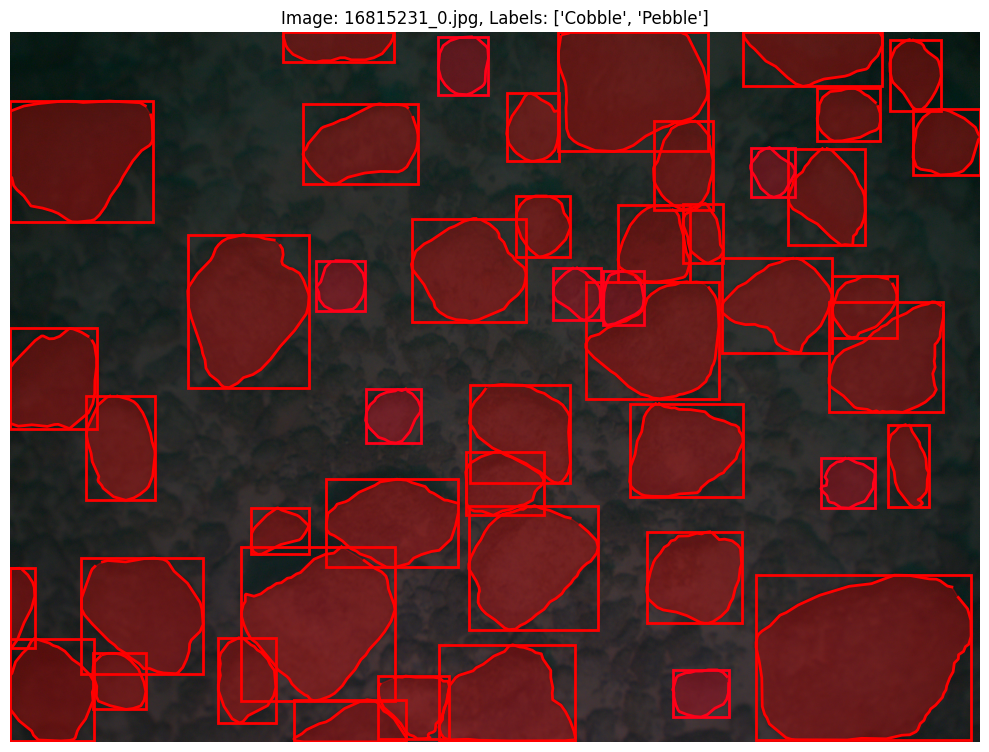

In [5]:
downloader.display_sample()

In [6]:
df = downloader.as_dataframe()  # .as_dict()
df.head(3)

# Do some data exploration, filtering as needed

,media,frame,image_name,image_path,x,y,width,height,polygon,label
0,16814883,0,16814883_0.jpg,e:\tator-tools\Data\Labeled_Data\AUV_Polygons\...,0.512695,0.218,0.006592,0.011000,"[[0.51416015625, 0.21833333333333332], [0.5129...",Pebble
1,16814812,0,16814812_0.jpg,e:\tator-tools\Data\Labeled_Data\AUV_Polygons\...,0.761475,0.911,0.008545,0.013000,"[[0.767578125, 0.911], [0.763916015625, 0.9113...",Pebble
2,16814894,0,16814894_0.jpg,e:\tator-tools\Data\Labeled_Data\AUV_Polygons\...,0.757812,0.613,0.006592,0.010667,"[[0.762939453125, 0.6133333333333333], [0.7602...",Pebble


# Convert Data into YOLO-formatted Dataset

In [7]:
# Set parameters
output_dir = "../Data/Labeled_Data/AUV_Polygons"
dataset_name = "YOLODataset_Detection"

train_ratio = 0.8
test_ratio = 0.1

task = 'detect' # 'detect' or 'segment'

In [8]:
# Create and process dataset
dataset = YOLODataset(
    data=df,
    output_dir=output_dir,
    dataset_name=dataset_name,
    train_ratio=train_ratio,
    test_ratio=test_ratio,
    task=task
)

In [9]:
# Process the dataset
dataset.process_dataset(move_images=False)  # Makes a copy of the images instead of moving them

Processing YOLO dataset with 8645 annotations...
Dataset split: 160 train, 20 valid, 20 test images


Writing detection labels:   0%|          | 0/200 [00:00<?, ?it/s]

Copying images:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset created at e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection
Classes: ['Pebble', 'Fallen Wood', 'Woody Debris', 'Unknown', '', 'Cobble', 'Boulder', 'Pebbles', 'Pebble Bed', 'Pebble bed', 'Fine Sediment']


Rendering Examples:   0%|          | 0/10 [00:00<?, ?it/s]

Rendered 10 examples to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection\examples


In [10]:
dataset.dataset_dir

'e:\\tator-tools\\Data\\Labeled_Data\\AUV_Polygons\\YOLODataset_Detection'

# Tile Dataset (Optional)

In [19]:
src = dataset.dataset_dir               # Source YOLO dataset directory
dst = f"{dataset.dataset_dir}_Tiled"    # Output directory for tiled dataset

config = TileConfig(
    # Size of each tile (width, height). Can be:
    # - Single integer for square tiles: slice_wh=640
    # - Tuple for rectangular tiles: slice_wh=(640, 480)
    slice_wh=(1920, 1080),

    # Overlap between adjacent tiles. Can be:
    # - Single float (0-1) for uniform overlap percentage: overlap_wh=0.1
    # - Tuple of floats for different overlap in each dimension: overlap_wh=(0.1, 0.1)
    # - Single integer for pixel overlap: overlap_wh=64
    # - Tuple of integers for different pixel overlaps: overlap_wh=(64, 48)
    overlap_wh=(0.2, 0.2),

    # Input image file extension to process
    input_ext=".jpg",

    # Output image file extension to save (default: same as input_ext)
    output_ext=None,

    # Type of YOLO annotations to process:
    # - "object_detection": Standard YOLO format (class, x, y, width, height)
    # - "instance_segmentation": YOLO segmentation format (class, x1, y1, x2, y2, ...)
    annotation_type="object_detection",

    # Include negative samples (tiles without any instances)
    include_negative_samples=True
)

tiler = YoloTiler(
    source=src,
    target=dst,
    config=config,
    num_viz_samples=15,                     # Number of samples to visualize
    show_processing_status=True,            # Show the progress of the tiling process
)

In [20]:
tiler.run()

2025-03-05 17:32:58,224 - YoloTiler - INFO - Found 193 images in train/ directory
2025-03-05 17:32:58,224 - YoloTiler - INFO - Found 193 label files in train/ directory
2025-03-05 17:32:58,225 - YoloTiler - INFO - Processing e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection\train\images\14768409_3532.jpg
train: Tile: 100%|██████████| 4/4 [00:00<00:00, 18.78tiles/s]
2025-03-05 17:32:58,533 - YoloTiler - INFO - Processing e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection\train\images\14768409_4806.jpg
train: Tile: 100%|██████████| 4/4 [00:00<00:00, 19.51tiles/s]
2025-03-05 17:32:58,816 - YoloTiler - INFO - Processing e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection\train\images\14768410_2469.jpg
train: Tile: 100%|██████████| 4/4 [00:00<00:00, 34.19tiles/s]
2025-03-05 17:32:58,977 - YoloTiler - INFO - Processing e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection\train\images\14768410_4353.jpg
train: Tile: 100%|███████

# Train a YOLO Model

In [13]:
# Initialize the trainer with the required parameters
trainer = ModelTrainer(
    training_data=f"{dataset.dataset_dir}_Tiled\\data.yaml",
    weights="yolov8m.pt",
    output_dir=f"{dataset.dataset_dir}_Tiled\\Training",
    name="AUV_Polygons_Detection",
    task=dataset.task,
    epochs=50,
    half=True,
    imgsz=640,
    single_cls=True,
    plots=True,
    batch=0.5,
)

In [14]:
# Train the model
trainer.train_model()

New https://pypi.org/project/ultralytics/8.3.84 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.0  Python-3.10.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 16384MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\data.yaml, epochs=50, time=None, patience=10, batch=0.5, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training, name=AUV_Polygons_Detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1

train: Scanning E:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\train\labels... 2076 images, 585 backgrounds, 0 corrupt: 100%|██████████| 2076/2076 [00:08<00:00, 241.00it/s]


train: New cache created: E:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\train\labels.cache


val: Scanning E:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\valid\labels... 440 images, 119 backgrounds, 0 corrupt: 100%|██████████| 440/440 [00:01<00:00, 238.85it/s]


val: New cache created: E:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\valid\labels.cache
Plotting labels to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 83 weight(decay=0.0), 90 weight(decay=0.0005), 89 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       9.7G      1.034      2.006      1.117        269        640: 100%|██████████| 130/130 [00:58<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        440       5730      0.887      0.473      0.736      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.3G      0.885      0.953      1.062        178        640: 100%|██████████| 130/130 [00:55<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]

                   all        440       5730      0.738      0.737      0.792       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50        10G     0.8681     0.8691      1.053        364        640: 100%|██████████| 130/130 [00:56<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.50it/s]

                   all        440       5730      0.725      0.709      0.759      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.4G     0.8582     0.8206      1.049        177        640: 100%|██████████| 130/130 [00:57<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.29it/s]

                   all        440       5730      0.757      0.743      0.797      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.66G     0.8527       0.78      1.043        246        640: 100%|██████████| 130/130 [00:57<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.48it/s]

                   all        440       5730      0.739      0.746      0.795      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.03G     0.8103     0.7394      1.031        371        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]

                   all        440       5730      0.806      0.757      0.834      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.9G     0.7979     0.7233      1.024        359        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]

                   all        440       5730      0.744      0.777      0.805      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.54G      0.786     0.7052      1.023        254        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        440       5730      0.787      0.768      0.847      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.4G     0.7659      0.669      1.008        186        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]

                   all        440       5730       0.81      0.744      0.833      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.12G      0.757     0.6595      1.008        166        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.833      0.783      0.868       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.1G     0.7386     0.6237     0.9977        123        640: 100%|██████████| 130/130 [00:57<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]

                   all        440       5730      0.787      0.781      0.832      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.57G     0.7384     0.6228     0.9956        146        640: 100%|██████████| 130/130 [00:59<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]

                   all        440       5730      0.775      0.787      0.839      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.85G     0.7247     0.6128     0.9926        266        640: 100%|██████████| 130/130 [00:59<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]

                   all        440       5730      0.797      0.808      0.858      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.49G     0.7189      0.601     0.9958        203        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]

                   all        440       5730      0.816      0.781      0.867      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.26G     0.7064     0.5715     0.9855        183        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730       0.85       0.82      0.889      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.1G     0.6876     0.5574     0.9734        264        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]

                   all        440       5730      0.829      0.821      0.882       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50        11G     0.6945     0.5506     0.9756        330        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.872      0.822        0.9      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.89G     0.6804      0.535      0.972        306        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]

                   all        440       5730      0.806      0.812      0.863      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.19G     0.6767     0.5386     0.9701        386        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        440       5730      0.861      0.811      0.893      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.1G     0.6662     0.5154     0.9635        197        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        440       5730      0.874      0.837      0.908       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.2G     0.6724     0.5065     0.9623        255        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        440       5730      0.829      0.806      0.888       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.26G     0.6512     0.4912     0.9568        208        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.838      0.819      0.894      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.84G     0.6359     0.4818     0.9503        269        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        440       5730      0.825      0.842      0.886       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.85G     0.6414     0.4716     0.9511        187        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        440       5730      0.895      0.862      0.929      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.5G     0.6221     0.4567     0.9476        241        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.866      0.853      0.915      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.92G     0.6148     0.4464     0.9432        142        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        440       5730      0.863      0.866      0.917      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50        10G     0.6121     0.4363     0.9356        238        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.864      0.867      0.917        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.6G     0.6018      0.432     0.9356        341        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730      0.881      0.866      0.917      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.86G     0.6032     0.4329     0.9376        176        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        440       5730      0.896      0.866      0.928      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.63G     0.5931     0.4209     0.9366        137        640: 100%|██████████| 130/130 [00:57<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]

                   all        440       5730      0.906      0.872      0.932      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.15G     0.5947     0.4142     0.9286        337        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

                   all        440       5730      0.885      0.873      0.919      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.84G     0.5862     0.4042     0.9309        582        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730      0.883      0.872      0.923      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.94G     0.5726     0.3985     0.9213        218        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730      0.901      0.883      0.934      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.4G      0.577     0.3892     0.9198        251        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.43it/s]

                   all        440       5730      0.876      0.888      0.925       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.38G     0.5671     0.3913     0.9208        246        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.909      0.888      0.939      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.26G     0.5591     0.3798     0.9116        310        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730       0.86      0.888      0.926      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.1G     0.5497     0.3786     0.9151        582        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        440       5730      0.936      0.894       0.95      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.45G     0.5404     0.3593     0.9105        253        640: 100%|██████████| 130/130 [00:57<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.932      0.896      0.951      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.92G     0.5431     0.3587     0.9097        207        640: 100%|██████████| 130/130 [00:56<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        440       5730      0.914      0.894      0.943      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.6G     0.5382     0.3554     0.9063        172        640: 100%|██████████| 130/130 [00:57<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730      0.923      0.898       0.95      0.857


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       8.9G     0.5033     0.3522     0.8873        167        640: 100%|██████████| 130/130 [00:55<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

                   all        440       5730      0.936      0.899      0.952       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.87G     0.4828     0.3169     0.8792        181        640: 100%|██████████| 130/130 [00:55<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.906      0.905       0.94      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.29G     0.4796     0.3219     0.8789        129        640: 100%|██████████| 130/130 [00:56<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

                   all        440       5730      0.933      0.897       0.95      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.04G     0.4777     0.3073     0.8772         40        640: 100%|██████████| 130/130 [00:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730      0.943      0.908      0.955      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.38G     0.4739     0.3025     0.8704        189        640: 100%|██████████| 130/130 [00:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        440       5730      0.918      0.914      0.948      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.49G     0.4625     0.2905     0.8731         22        640: 100%|██████████| 130/130 [00:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        440       5730       0.93      0.904       0.95      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.91G     0.4476     0.2842     0.8628        134        640: 100%|██████████| 130/130 [00:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.54it/s]

                   all        440       5730      0.943      0.914      0.955      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.84G      0.447      0.281      0.863        213        640: 100%|██████████| 130/130 [00:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]

                   all        440       5730      0.937      0.907      0.952      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.16G      0.435     0.2764      0.864         71        640: 100%|██████████| 130/130 [00:55<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

                   all        440       5730      0.937      0.912      0.955       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.35G     0.4358     0.2722     0.8605         85        640: 100%|██████████| 130/130 [00:56<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

                   all        440       5730      0.944      0.909      0.955      0.872



50 epochs completed in 0.914 hours.
Optimizer stripped from e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection2\weights\last.pt, 46.8MB
Optimizer stripped from e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection2\weights\best.pt, 46.8MB

Validating e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection2\weights\best.pt...
Ultralytics 8.3.0  Python-3.10.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 16384MiB)
Model summary (fused): 236 layers, 23,209,201 parameters, 0 gradients, 67.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


                   all        440       5730       0.94      0.913      0.955      0.873
                Pebble        321       5730       0.94      0.913      0.955      0.873
Speed: 0.2ms preprocess, 4.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection2
Training completed.


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000014CD7FE66E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [15]:
# Evaluate on the model (if test data is available)
trainer.evaluate_model()

Ultralytics 8.3.0  Python-3.10.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 16384MiB)
Model summary (fused): 236 layers, 23,209,201 parameters, 0 gradients, 67.5 GFLOPs


val: Scanning E:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\test\labels... 400 images, 105 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:01<00:00, 279.51it/s]

val: New cache created: E:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\test\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.44it/s]


                   all        400       5102      0.941      0.931      0.964      0.886
                Pebble        295       5102      0.941      0.931      0.964      0.886
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Saving e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection22\predictions.json...
Results saved to e:\tator-tools\Data\Labeled_Data\AUV_Polygons\YOLODataset_Detection_Tiled\Training\AUV_Polygons_Detection22


# Inference on Video

In [19]:
# Set parameters
model_weights = "E:\\tator-tools\\Data\\Labeled_Data\\AUV_Polygons\\YOLODataset_Detection_Tiled\\Training\\AUV_Polygons_Detection\\weights\\best.pt"

video_path = "E:\\tator-tools\\Data\\Raw_Videos\\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted.mp4"
output_dir = "E:\\tator-tools\\Data\\Inference_Results"


In [21]:
inferencer = VideoInferencer(
    weights_path=model_weights,
    model_type='yolo',
    video_path=video_path,
    output_dir=output_dir,
    start_at=1000,
    end_at=2000,
    conf=0.5,
    iou=0.3,
    track=False,
    segment=False,
    sahi=False,
    show=True
)

NOTE: Device set as cuda:0


In [ ]:
inferencer.inference()